<a href="https://colab.research.google.com/github/chan-98/single-cell-RNAseq-analysis/blob/main/scRNAseq_GSE171524_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset link: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE171524
The 29 CSV files provided in Supplementary table in GSE171524_RAW.tar folder was used.

In [ ]:
!pip install scanpy scvi-tools doubletdetection celltypist hyperopt "ray[tune]" scikit-misc leidenalg

#The Dataset

*COVID-19 single-cell transcriptomic lung atlas*

**GSE171524**
 - Supplementary files - 29 samples

In [ ]:
!wget ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE171nnn/GSE171524/suppl/GSE171524_RAW.tar

In [ ]:
!mkdir -p GSE171524_RAW && mv GSE171524_RAW.tar GSE171524_RAW/.
!cd GSE171524_RAW && tar -xf GSE171524_RAW.tar && rm GSE171524_RAW.tar && cd ../

In [ ]:
import os
file_paths = ["GSE171524_RAW/" + f for f in os.listdir("GSE171524_RAW/")]
print(file_paths)

In [ ]:
import scanpy as sc
import pandas as pd
import numpy as np

In [ ]:
def load(fpath):
  """Load anndata and make new columns for sample metadata"""
  adata = sc.read_csv(fpath).T
  adata.obs["Sample"] = fpath.split("/")[1].split("_")[0]
  return adata

Performing analysis only on 2 of the count matrices due to RAM constraints

In [ ]:
adatas = [load(x) for x in file_paths[:2]]  # Remove the [:2] for complete analysis
adatas

In [ ]:
adatas[1].obs.head(n=2)

In [ ]:
adatas[1].var

In [ ]:
adatas[1].X

# QC

Since the data is already UMI filtered matrix, we can skip the filtering part.

In [ ]:
def qc(adata):
  sc.pp.filter_genes(adata, min_cells = 10)
  # Reducing dimensions to top 2000 genes only
  sc.pp.highly_variable_genes(adata, n_top_genes = 2000, subset = True, flavor = 'seurat_v3')
  # Remove artifaacts and contaminants
  adata.var["mt"] = adata.var_names.str.startswith(("MT-", "mt-", "Mt-"))
  adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
  adata.var["hb"] = adata.var_names.str.startswith(("HB", "Dll"))
  sc.pp.normalize_total(adata, target_sum=1e4)
  sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True)
  remove_cols = ["total_counts_mt", "log1p_total_counts_mt", "total_counts_ribo",
                 "log1p_total_counts_ribo", "total_counts_hb", "log1p_total_counts_hb"]
  adata.obs.drop(columns=remove_cols, inplace=True)
  return adata

In [ ]:
adatas = [qc(adata) for adata in adatas]
adatas

Means, Variances and Variances_norm are added when calculating highly variable genes.

In [ ]:
adatas[1].var

In [ ]:
adatas[1].obs

In [ ]:
df_adatas = pd.concat([adata.obs for adata in adatas])
df_adatas = df_adatas.sort_values("Sample")
df_adatas

Plot MT, RIBO and HB counts, n_genes and other metrics per **sample**

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
#%matplotlib inline

In [ ]:
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

def plotkde(df_adatas, value):
  sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
  g = sns.FacetGrid(df_adatas, row="Sample", hue="Sample", aspect=15, height=1.0, palette="tab20")

  g.map(sns.kdeplot, value, clip_on=False, fill=True, alpha=1, linewidth=1.5)
  g.map(sns.kdeplot, value, clip_on=False, color="w", lw=2, alpha=1)
  g.map(plt.axhline, y=0, lw=2, clip_on=False)
  g.map(label, value)

  g.set_titles("")
  g.set(yticks=[])
  g.despine(bottom=True, left=True)

  for ax in g.axes.flat:
    ax.axvline(x=df_adatas[value].median(), color='r', linestyle='-')

  plt.show()

In [ ]:
plotkde(df_adatas, "pct_counts_ribo")

In [ ]:
plotkde(df_adatas, "n_genes_by_counts")

In [ ]:
plotkde(df_adatas, "pct_counts_in_top_20_genes")

For unfiltered data, run the following code to filter outliers:

In [ ]:
def filter_outliers(adata):
  sc.pp.filter_genes(adata, min_cells = 10)
  upper_lim = np.quantile(adata.obs.n_genes_by_counts.values, .98)    # upper_lim ~= 3000
  print(f"Upper limit is: {upper_lim}")
  sc.pp.filter_cells(adata, max_genes=upper_lim)
  adata = adata[adata.obs.pct_counts_mt < 20]
  adata = adata[adata.obs.pct_counts_ribo < 2]
  return adata

adatas = [filter_outliers(adata) for adata in adatas]

In [ ]:
adatas[1].obs

# Normalization

Normalise every cell to 10,000 UMI (Standard, can be changed acc to data)


In [ ]:
def norm(adata):
  sc.pp.normalize_total(adata, target_sum=1e4)
  sc.pp.log1p(adata)
  # Storing rawdata before modification
  adata.raw = adata
  sc.pp.filter_genes(adata, min_cells=10)
  return adata

In [ ]:
adatas = [norm(adata) for adata in adatas]

In [ ]:
adatas[0].X.sum(axis=1) # After normalisation

In [ ]:
adatas[0].X

# Clustering

In [ ]:
ad1 = adatas[1]
sc.pl.highly_variable_genes(ad1)

As it is already clustered and filtered data, only highly variable genes are present which are shown by black spots (other genes are generally shown as grey)

Now we have a set of 2000 genes. Further dimensionality reduction include:
- Regression
- Scaling (Normalization)
- Principal Component Analysis to reduce (by default - reduces to 50 PCs (50 genes))

And plot the 50 PCs to see how much they contribute to the variance.

In [ ]:
def dimreduce(adata):
  """
  Dimensionality reduction for single AnnData object
  """
  # Filtering out the genes which are not highly variable
  adata = adata[:, adata.var.highly_variable]
  # Eliminating differences arising due to sampling depth, mtRNA and ribosomal RNA
  sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt', 'pct_counts_ribo'])
  # Scaling (to normalise) each gene to the unit variance of the gene
  sc.pp.scale(adata, max_value=10)
  # PCA analysis (by default keeps top 50PCs)
  sc.tl.pca(adata, svd_solver='arpack')
  sc.pl.pca_variance_ratio(adata, log=True, n_pcs = 50)

ad1 = adatas[1].copy()
dimreduce(ad1)

Calculate the NEIGHBOURS of the top 30 PCs (distances). Neighbours denote similar cells, and similar cells will be clustered together.




In [ ]:
sc.pp.neighbors(ad1, n_pcs = 30)

In [ ]:
ad1

In [ ]:
ad1.obsp['connectivities']

In [ ]:
ad1.obsp['distances'].toarray()

In [ ]:
ad1.obs

Convert the 30 dimensions to 2 dimensions using UMAP clustering based on connectivities and distances.

In [ ]:
sc.pp.neighbors(ad1, n_pcs = 30)

In [ ]:
sc.tl.umap(ad1)
sc.pl.umap(ad1)

Assign colours and annotate each cluster.

Resolution closer to 1 gives more clusters, closer to 0 gives fewer clusters, start with 0.5 and adjust accordingly.

In [ ]:
sc.tl.leiden(ad1, resolution = 0.5)

In [ ]:
ad1.obs

Replot the UMAP based on the col `leiden`

In [ ]:
sc.pl.umap(ad1, color=['leiden'])

This data will be annotated using `celltypist`

---------
Clustering for ALL `adatas` (integrated)

In [ ]:
"""For all adata objects (adatas)"""

adata_combined = sc.concat(adatas)
adata_combined

In [ ]:
adata_combined.X

This is a dense matrix - consumes more memory, and has actual physical values for each entry.

If our data was not already 2 dimensional and processed, we would have to convert it to sparse matrix.

In [ ]:
from scipy.sparse import csr_matrix

In [ ]:
adata_combined.X = csr_matrix(adata_combined.X)
adata_combined.X

In [ ]:
adata_combined.write_h5ad('combined.h5ad') # Save

In [ ]:
# adata_combined = sc.read_h5ad('combined.h5ad')

adata_combined.obs.groupby("Sample").count()

If the dimension ( `n_vars` ) was too high (in thousands or tens of thousands instead of 2), do the following to reduce dims:

In [ ]:
sc.pp.filter_genes(adata_combined, min_cells = 100)

Now we need to correct for batch effects using regression, scaling and perform PCA analysis

In [ ]:
import scvi

In [ ]:
def dimreduce(adata):
  """
  Clustering for all adata objects combined
  """
  # Save the counts
  adata.layers['counts'] = adata.X.copy()
  print("Normalising raw counts")
  sc.pp.normalize_total(adata, target_sum = 1e4)
  sc.pp.log1p(adata)
  adata.raw = adata
  print(f"This is what data looks like: {adata.obs.head(n=2)}")
  print("Fetching highly variable genes (top 2000)")
  sc.pp.highly_variable_genes(adata, n_top_genes=2000,
                              subset = True, layer = 'counts',
                              flavor = "seurat_v3", batch_key="Sample") # provide batch_key for combined adata
  print("Setting up SCVI model")
  scvi.model.SCVI.setup_anndata(adata, layer = "counts",
                             categorical_covariate_keys=["Sample"],
                             continuous_covariate_keys=['pct_counts_mt', 'total_counts', 'pct_counts_ribo'])
  model = scvi.model.SCVI(adata)
  print("Training model")
  model.train()
  print(f"Trained SCVI model (np array) looks like: f{model.get_latent_representation().shape}")
  print("Computing X_scVI")
  # Save the model
  adata.obsm["X_scVI"] = model.get_latent_representation()
  # Add layer for normalized values
  adata.layers['scvi_normalized'] = model.get_normalized_expression(library_size = 1e4)
  print("Calculating neighbours using SCVI results")
  sc.pp.neighbors(adata, use_rep = 'X_scVI') # gives distances and connectivities
  print("UMAP clustering")
  sc.tl.umap(adata)
  sc.tl.leiden(adata, resolution = 0.5)
  #sc.pl.umap(adata, color = ['leiden', 'Sample'], frameon = False)
  print("Done")
  return adata

integrated_adata = dimreduce(adata_combined)

In [ ]:
integrated_adata.write_h5ad('integrated.h5ad')

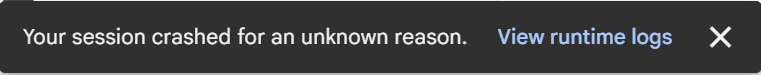

***Note: May fail due to limited compute resources, try again, or proceed with `ad1`***

# Cell Typist for Cluster Annotation

In [ ]:
import celltypist
from celltypist import models

Looking at available models for cell type classification.

Documentation provided at https://github.com/Teichlab/celltypist is followed for processing and plotting.

In [ ]:
models.get_all_models()

In [ ]:
model_pancreas = models.Model.load(model="Human_Lung_Atlas.pkl")

In [ ]:
integrated_adata.obs.head(n=3)

Select model: Human Lung Atlas

In [ ]:
def predict_cells(adata):
  sc.pp.normalize_total(adata, target_sum=1e4)
  sc.pp.log1p(adata)
  #sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=3000)
  #adata.X = adata.X.toarray()

  predictions = celltypist.annotate(adata, model=model_pancreas, majority_voting=False)
  predictions_adata = predictions.to_adata()
  adata.obs["lung_label"] = predictions_adata.obs.loc[adata.obs.index, "predicted_labels"]
  adata.obs["lung_score"] = predictions_adata.obs.loc[adata.obs.index, "conf_score"]

  return adata

In [ ]:
predictions = predict_cells(integrated_adata.copy())

In [ ]:
predictions.obs.head(n=3)

In [ ]:
predictions.obs["Sample"].unique()

In [ ]:
predictions.obs.to_csv('PREDICTIONS_GSM5226575_GSM5226599.csv')

In [ ]:
predictions.obs["conf_score"].describe()

In [ ]:
sc.pl.umap(predictions, color=["leiden", "conf_score"], wspace=0.4)

In [ ]:
sc.pl.umap(predictions, color=["predicted_labels"])

Comparing leiden clusters with predicted labels

In [ ]:
pd.crosstab(predictions.obs["leiden"], predictions.obs["predicted_labels"])


In [ ]:
# Remove low-confidence predictions
predictions = predictions[predictions.obs["conf_score"] > 0.6, :]
# Or can be labelled as unknown
#predictions.obs.loc[predictions.obs["conf_score"] < 0.6, "predicted_labels"] = "unknown"

# Export to .h5ad

Refine metadata and remove unwanted cols

In [ ]:
GSM5226575_GSM5226599_annotated = predictions.copy()
GSM5226575_GSM5226599_annotated.obs = GSM5226575_GSM5226599_annotated.obs[[
    "Sample", "leiden", "n_genes_by_counts",
    "total_counts", "pct_counts_mt",
    "predicted_labels", "conf_score"
]]

# Keeping original cluster annotations and predicted cluster annotations for comparison.

In [ ]:
GSM5226575_GSM5226599_annotated.write("GSM5226575_GSM5226599_annotated.h5ad")

In [ ]:
!ls

Visualising cell type distribution

In [ ]:
GSM5226575_GSM5226599_annotated.obs["predicted_labels"].value_counts(normalize=True).plot(kind="bar")


Checking UMAP for marker genes (test)

In [ ]:
# sc.pl.umap(GSM5226575_GSM5226599_annotated, color=["INS", "GCG", "SST", "PPY"])
# Throws key error because this dataset does not contain marker genes

Future work: Marker genes can be identified.